In [1]:
!pip install --quiet --no-cache-dir torch==2.2.2 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 309.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 316.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 350.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 125.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 252.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 257.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 313.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 325.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 320.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 333.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 322.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━

In [1]:
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg


In [2]:
import scipy.integrate 
solve_ivp = scipy.integrate.solve_ivp 

In [3]:
def rk4(fun, y0, t, h, *args, **kwargs):
    h2 = h/2.0
    k1 = fun(y0, t, *args, **kwargs)
    k2 = fun(y0+ (h2 * k1), t+h2, *args, **kwargs)
    k3 = fun(y0+ (h2 * k2), t+h2, *args, **kwargs)
    k4 = fun(y0 + (h*k3), t+h2, *args, **kwargs)

    dy =  (1/6)*h*(k1+(2*(k2+k3))+k4)

    return dy 

def L2Loss(u,v):
    return (u-v).pow(2).mean()


In [4]:
class BaselineMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
       super().__init__()
       self.layer_1 = nn.Linear(in_features=input_dim, out_features=hidden_dim)
       self.layer_2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
       self.layer_3 = nn.Linear(in_features=hidden_dim, out_features=output_dim)
       self.tanh = nn.Tanh()

       for l in [self.layer_1, self.layer_2, self.layer_3]:
           nn.init.orthogonal_(l.weight)
       
    def forward(self, x):
           h = self.tanh(self.layer_1(x))
           h = self.tanh(self.layer_2(h))

           return self.layer_3(h)

In [5]:
class HNN(nn.Module):
    #NN that learns vector fields that are conservative or solenoidal or their combination
    def __init__(self, input_dim, differentiable_model, field_type='solenoidal', baseline=False, assume_canonical_coords=True):
        super(HNN, self).__init__()

        self.baseline = baseline #if set to true, just returns raw outpus with no physics bias
        self.differentiable_model = differentiable_model
        self.assume_canonical_coords = assume_canonical_coords #whether J = standard symplectic matrix 
        #symplectic matrix J (when assume_canonical_coords is True and dim=2) or general antisymmetric one (for higher dim) 
        # self.M = self.permutation_tensor(input_dim) 
        self.register_buffer("M", self.permutation_tensor(input_dim))
        self.field_type = field_type


    def forward(self, x):
        if self.baseline:
            #if baseline=True, just a vanilla neural ODE and return raw output
            return self.differentiable_model(x) 
        y = self.differentiable_model(x)
        assert y.dim()==2 and y.shape[1] == 2, "Ouput should be [batch_size, 2]"
        return y.split(1,1)
        
    def rk4_time_derivative(self, x, h):
        return rk4(fun=self.time_derivative, y0=x, t=0, h=h)
    #Core HNN function 
    def time_derivative(self, x, t=None, separate_fields=False):
        #Takes in a batch of inputs x = (q,p) and returns the time derivative vector field z' 
        if self.baseline:
            return self.differentiable_model(x)
        
        F1, F2 = self.forward(x) #Split the model's output into two scalar potentials, F1(conservative field) & F2(solenoidal field)

        #Initializing borth vector fields as 0 
        conservative_field = torch.zeros_like(x)
        solenoidal_field = torch.zeros_like(x)
        
        #For conservative field
        if self.field_type != 'solenoidal':
            dF1 = torch.autograd.grad(F1.sum(), x, create_graph=True)[0]
            conservative_field = dF1 @ torch.eye(*self.M.shape)
        
        #For solenoidal field 
        if self.field_type != 'conservative':
            dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] 
            solenoidal_field = dF2@self.M.t()

        if separate_fields:
            return [conservative_field, solenoidal_field]
        
        return conservative_field + solenoidal_field 
    
    def permutation_tensor(self, n):
        M = None 
        if self.assume_canonical_coords:
            #Normal symplectic matrix construction
            M = torch.eye(n)
            M = torch.cat([M[n//2:], -M[:n//2]])
        else:
            #Constructs the Levi-Civita permutation tensor for higher order fields
            M = torch.ones(n,n) #creates a matrix of ones
            M *= 1-torch.eye(n,n) #clears the diagonals 
            M[::2] *= -1 #pattern of signs 
            M[:,::2] *= -1 

            for i in range(n): #make asymmetric 
                for j in range(i+1, n):
                    M[i,j] *= -1 
        
        return M 



In [6]:
#Energy 
def potential_energy(state):
    #U = sum(i, j>i) G * m_i * m_j / r_ij 
    tot_energy = np.zeros((1,1,state.shape[2]))
    for i in range(state.shape[0]):
        for j in range(i+1, state.shape[0]):
            r_ij = ((state[i:i+1,1:3]-state[j:j+1, 1:3])**2).sum(1, keepdims=True)**.5
            m_i = state[i:i+1, 0:1]
            m_j = state[j:j+1,0:1]

    tot_energy += m_i*m_j / r_ij #G=1 for easier calculations 

    U = -tot_energy.sum(0).squeeze()

    return U 


def kinetic_energy(state):
    #T = sum(i) 0.5*m*v^2 
    energies = 0.5 * state[:,0:1] * (state[:,3:5]**2).sum(1, keepdims=True)
    T = energies.sum(0).squeeze()
    return T 

def total_energy(state):
    return potential_energy(state) + kinetic_energy(state)

#Dynamics 
def get_accelerations(state, epsilon=0):
    #shape of state is [bodies x properties]
    net_accs = [] # [nbodies x 2]
    for i in range(state.shape[0]): #number of bodies 
        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
        displacements = other_bodies[:,1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
        distances = (displacements**2).sum(1, keepdims=True)**0.5 
        masses = other_bodies[:, 0:1] #index 0 -> mass 
        pointwise_accs = masses*displacements / (distances**3 + epsilon) #G=1
        net_acc = pointwise_accs.sum(0, keepdims=True)
        net_accs.append(net_acc)

    net_accs = np.concatenate(net_accs, axis=0)
    return net_accs

def update(t, state):
    state = state.reshape(-1,5) # [bodies, properties]
    deriv = np.zeros_like(state)
    deriv[:,1:3] = state[:,3:5] #dx,dy=vx,vy
    deriv[:,3:5] = get_accelerations(state)

    return deriv.reshape(-1)

#Integration
def get_orbit(state, update_fn=update, t_points=100, t_span=[0,2], **kwargs):
    if not 'rtol' in kwargs.keys():
        kwargs['rotl'] = 1e-9

    orbit_settings = locals()

    nbodies = state.shape[0]
    t_eval = np.linspace(t_span[0], t_span[1], t_points)
    orbit_settings['t_eval'] = t_eval 

    path = solve_ivp(fun=update_fn, t_span=t_span, y0=state.flatten(), 
                     t_eval=t_eval, **kwargs)
    orbit = path['y'].reshape(nbodies,5,t_points)
    return orbit, orbit_settings 


#Intializing the two bodies 
def random_config(orbit_noise=5e-2, min_radius=0.5, max_radius=1.5):
    state = np.zeros((2,5))
    state[:,0] = 1
    pos = np.random.rand(2)*(max_radius-min_radius) + min_radius
    r = np.sqrt(np.sum((pos**2)))

    #velocity that yields a circular orbit 
    vel = np.flipud(pos)/(2*r**1.5)
    vel[0] *= -1 
    vel *= -1 + orbit_noise*np.random.randn()

    #make the circular orbits, slightly elliptical 
    state[:,1:3] = pos 
    state[:,3:5] = vel
    state[1,1:]  *= -1 

    return state 

#Helper Function
def coords2state(coords, nbodies=2, mass=1):
    timesteps = coords.shape[0]
    state = coords.T
    state = state.reshape(-1, nbodies, timesteps).transpose(1,0,2)
    mass_vec = mass * np.ones((nbodies, 1, timesteps))
    state = np.concatenate([mass_vec, state], axis=1)
    return state 

#Integrate orbits 
def sample_orbits(timesteps=50, trials=1000, nbodies=2, orbit_noise=5e-2,
                  min_radius=0.5, max_radius=1.5, t_span=[0, 20], verbose=False, **kwargs):
    
    orbit_settings = locals()
    if verbose:
        print("Making a dataset of near-circular 2-body orbits:")
    
    x, dx, e = [], [], []
    N = timesteps*trials
    while len(x) < N:

        state = random_config(orbit_noise, min_radius, max_radius)
        orbit, settings = get_orbit(state, t_points=timesteps, t_span=t_span, **kwargs)
        batch = orbit.transpose(2,0,1).reshape(-1,10)

        for state in batch:
            dstate = update(None, state)
            
            # reshape from [nbodies, state] where state=[m, qx, qy, px, py]
            # to [canonical_coords] = [qx1, qx2, qy1, qy2, px1,px2,....]
            coords = state.reshape(nbodies,5).T[1:].flatten()
            dcoords = dstate.reshape(nbodies,5).T[1:].flatten()
            x.append(coords)
            dx.append(dcoords)

            shaped_state = state.copy().reshape(2,5,1)
            e.append(total_energy(shaped_state))

    data = {'coords': np.stack(x)[:N],
            'dcoords': np.stack(dx)[:N],
            'energy': np.stack(e)[:N] }
    return data, orbit_settings

def make_orbits_dataset(test_split=0.2, **kwargs):
    data, orbit_settings = sample_orbits(**kwargs)

    #making a train/test split 
    split_ix = int(data['coords'].shape[0]*test_split)
    split_data = {}
    for k, v in data.items():
        split_data['train_'+k], split_data['test_'+k] = v[split_ix:], v[:split_ix]
    
    data = split_data 

    data['meta'] = orbit_settings
    return data 




In [7]:
DPI = 300
input_dim = 2*4 # two bodies, each with q_x, q_y, p_z, p_y
hidden_dim = 200
learn_rate = 1e-3
input_noise = 0.
batch_size = 200
total_steps =  1500
field_type= 'solenoidal'
print_every =  200
verbose = True
# 'name': '2body'
seed = 0

### Visualizing Examples

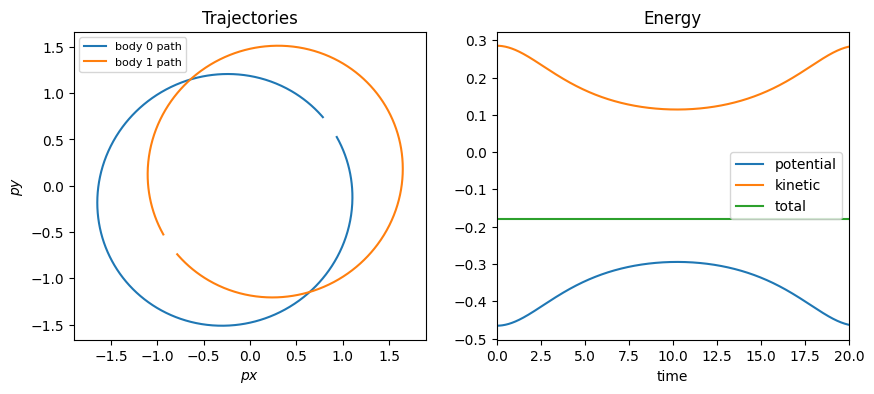

In [8]:
np.random.seed(2)
state = random_config()
orbit, settings = get_orbit(state, t_points=1000, t_span = [0, 20], rtol = 1e-10)

# draw trajectories
fig = plt.figure(figsize=[10,4], dpi=100)
plt.subplot(1,2,1)
plt.title('Trajectories')
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('$px$') ; plt.ylabel('$py$')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])

plt.show()

In [9]:
#Loading the models 
baseline_output_dim = input_dim 
output_dim = 2 
nn_model = BaselineMLP(input_dim, hidden_dim, output_dim)
model = HNN(input_dim, differentiable_model=nn_model, field_type=field_type)
baseline_model = BaselineMLP(input_dim,hidden_dim,baseline_output_dim)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [11]:
device

device(type='cuda')

In [12]:
model = model.to(device)
baseline_model = baseline_model.to(device)
nn_model = nn_model.to(device)

In [13]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
base_optim = torch.optim.Adam(baseline_model.parameters(), lr=1e-3, weight_decay=1e-4)

In [14]:
data = make_orbits_dataset(seed=0)

x_train = torch.tensor(data['train_coords'], requires_grad=True, dtype=torch.float32)  # z = [q p]
x_test = torch.tensor(data['test_coords'], requires_grad=True, dtype=torch.float32)

dxdt_train = torch.tensor(data['train_dcoords'], dtype=torch.float32)  # dz/dt = [dq/dt dp/dt]
dxdt_test = torch.tensor(data['test_dcoords'], dtype=torch.float32)

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `seed`, `rotl`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


In [15]:
print(data.keys())


dict_keys(['train_coords', 'test_coords', 'train_dcoords', 'test_dcoords', 'train_energy', 'test_energy', 'meta'])


### Model Training and Testing

In [16]:
#normal training loop
epochs = total_steps 
stats = {'training_loss':[], 'testing_loss':[] }
for epoch in range(epochs):

    x_train = x_train.to(device)
    dxdt_train = dxdt_train.to(device)


    baseline_model.train()

    dxdt_hat_train = baseline_model(x_train)

    train_loss = L2Loss(dxdt_train, dxdt_hat_train)
    stats['training_loss'].append(train_loss)

    base_optim.zero_grad()

    train_loss.backward()

    base_optim.step()

    #testing 
    baseline_model.eval()
    with torch.inference_mode():
        # print(x_test.shape)
        # print(dxdt_hat_train.shape)
        x_test = x_test.to(device)
        dxdt_test = dxdt_test.to(device)
        x_test.requires_grad_(True) #enable gradient tracking for the in graph gradient
        dxdt_hat_test = baseline_model(x_test) 
        test_loss = L2Loss(dxdt_hat_test, dxdt_test)
        stats['testing_loss'].append(test_loss)
    
    if epoch % print_every == 0 :
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}  | Test Loss: {test_loss:.5f} ")

Epoch: 0 | Train Loss: 0.07256  | Test Loss: 0.02563 
Epoch: 200 | Train Loss: 0.00036  | Test Loss: 0.00040 
Epoch: 400 | Train Loss: 0.00034  | Test Loss: 0.00039 
Epoch: 600 | Train Loss: 0.00034  | Test Loss: 0.00038 
Epoch: 800 | Train Loss: 0.00033  | Test Loss: 0.00037 
Epoch: 1000 | Train Loss: 0.00033  | Test Loss: 0.00037 
Epoch: 1200 | Train Loss: 0.00032  | Test Loss: 0.00036 
Epoch: 1400 | Train Loss: 0.00032  | Test Loss: 0.00036 


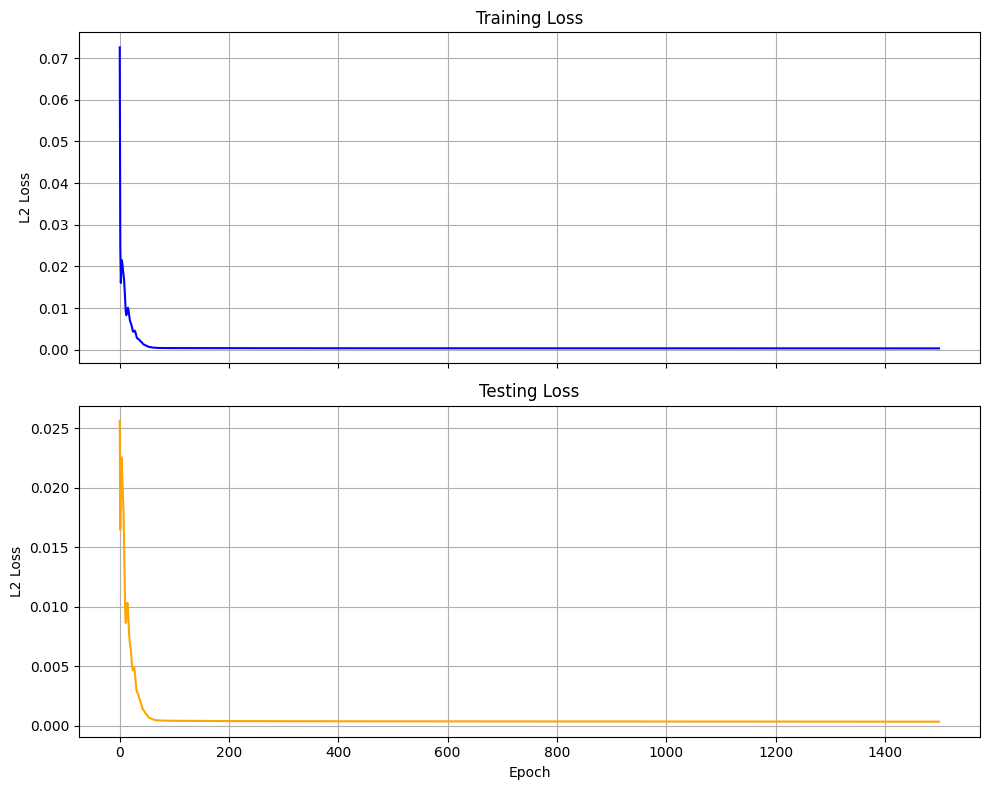

In [17]:
# Convert loss tensors to floats
train_losses = [loss.item() for loss in stats['training_loss']]
test_losses = [loss.item() for loss in stats['testing_loss']]

# Create two subplots: one for training loss, one for testing loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
axs[0].plot(train_losses, color='blue')
axs[0].set_title('Training Loss')
axs[0].set_ylabel('L2 Loss')
axs[0].grid(True)

# Plot testing loss
axs[1].plot(test_losses, color='orange')
axs[1].set_title('Testing Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 Loss')
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [18]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train, dxdt_train)
test_dataset = TensorDataset(x_test, dxdt_test)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# --- Hyperparameters ---
batch_size = 32  # Reduce if OOM
epochs = 500
print_every = 100

# --- Dataset Wrapping ---
train_dataset = TensorDataset(x_train, dxdt_train)
test_dataset = TensorDataset(x_test, dxdt_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Training & Testing ---
stats = {'training_loss': [], 'testing_loss': []}

for epoch in range(epochs):
    model.train()
    train_losses = []

    for x_batch, dxdt_batch in train_loader:
        x_batch = x_batch.clone().detach().to(device).requires_grad_(True)
        dxdt_batch = dxdt_batch.clone().detach().to(device)

        dxdt_hat = model.time_derivative(x_batch)
        loss = L2Loss(dxdt_hat, dxdt_batch)

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_losses.append(loss.item())

        # Free memory
        del x_batch, dxdt_batch, dxdt_hat, loss
        torch.cuda.empty_cache()

    stats['training_loss'].append(sum(train_losses) / len(train_losses))

    # --- Evaluation ---
    model.eval()
    test_losses = []

    for x_batch, dxdt_batch in test_loader:
        x_batch = x_batch.clone().detach().to(device).requires_grad_(True)
        dxdt_batch = dxdt_batch.clone().detach().to(device)

        dxdt_hat = model.time_derivative(x_batch)

        loss = L2Loss(dxdt_hat, dxdt_batch)
        test_losses.append(loss.item())

        # Free memory
        del x_batch, dxdt_batch, dxdt_hat, loss
        torch.cuda.empty_cache()

    stats['testing_loss'].append(sum(test_losses) / len(test_losses))

    # --- Logging ---
    if epoch % print_every == 0:
        print(f"Epoch {epoch:04d} | Train Loss: {stats['training_loss'][-1]:.6f} | Test Loss: {stats['testing_loss'][-1]:.6f}")


Epoch 0000 | Train Loss: 0.001726 | Test Loss: 0.000368
Epoch 0100 | Train Loss: 0.000131 | Test Loss: 0.000152
Epoch 0200 | Train Loss: 0.000133 | Test Loss: 0.000142


In [ ]:
# Convert loss tensors to floats
train_losses = [loss.item() if hasattr(loss, 'item') else loss for loss in stats['training_loss']]
test_losses = [loss.item() if hasattr(loss, 'item') else loss for loss in stats['testing_loss']]


# Create two subplots: one for training loss, one for testing loss
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot training loss
axs[0].plot(train_losses, color='blue')
axs[0].set_title('Training Loss')
axs[0].set_ylabel('L2 Loss')
axs[0].grid(True)

# Plot testing loss
axs[1].plot(test_losses, color='orange')
axs[1].set_title('Testing Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 Loss')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,2).T
    return deriv.reshape(-1)

In [ ]:
np.random.seed(2)
t_points = 2000
t_span = [0,50]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn = lambda t, y0: model_update(t, y0, baseline_model)
base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

In [ ]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i, path in enumerate(base_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax) 

plt.subplot(1,3,3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(base_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(base_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(base_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()

In [ ]:
np.random.seed(2)
t_points = 2000
t_span = [0,50]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

update_fn = lambda t, y0: model_update(t, y0, model)
hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

In [ ]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i, path in enumerate(hnn_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax) 

plt.subplot(1,3,3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(hnn_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(hnn_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(hnn_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()

In [ ]:
# integrate trajectories
t_points = 100
t_span = [0,10]
num_orbits = 50
update_fn = lambda t, y0: model_update(t, y0, model)

orbits = []
energies = []
for i in range(num_orbits):
    np.random.seed(i)
    state = random_config()
    mini_orbit, _ = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    orbits.append(mini_orbit)
    
    # convert from state to canonical coords
    np_coords = mini_orbit[:,1:,:].transpose(1,0,2).reshape(8, -1).T
    coords = torch.tensor( np_coords, requires_grad=True, dtype=torch.float32)
    F1, F2 = model.forward(coords)
    energies.append(F2.data.numpy().squeeze())

energies = np.stack(energies)
e_order = np.argsort(energies.mean(1))
energies = energies[e_order]

In [ ]:
fig = plt.figure(figsize=[4,3], dpi=150)
plt.subplot(1,1,1)

import matplotlib.pylab as pl
colors = pl.cm.seismic(np.linspace(0,1,num_orbits))
for i, e in enumerate(energies):
    plt.plot(e, color=colors[i])
    
plt.xlabel('Integration step')
plt.ylabel('$f_{\\theta}(x)$')
plt.title("Scalar output of HNN")
plt.tight_layout() ; plt.show()

In [ ]:
def plot_orbits(fig, k, tail=10000, pfrac=0.05, fs=28, ms=40, lw=3, tpad=15):
    xmin = ymin = np.min([orbit[:,1,:].min(), orbit[:,2,:].min()])
    xmax = ymax = np.max([orbit[:,1,:].max(), orbit[:,2,:].max()])
    pad = (xmax-xmin)*pfrac
    xmin -= pad
    xmax += pad
    ymin -= pad
    ymax += pad

    colors = [(0,0,0), (.6,.6,.6)]
    t = max(0, k-tail)

    plt.subplot(1,3,1)
    plt.title('Ground truth', fontsize=fs, pad=tpad)
    for i, path in enumerate(orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')

    colors = [(1,0,0), (1,.6,.6)]
    plt.subplot(1,3,2)
    plt.title('Baseline NN', fontsize=fs, pad=tpad)
    for i, path in enumerate(base_orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal') 

   colors = [(0,0,1), (.6,.6,1)]
    plt.subplot(1,3,3)
    plt.title('Hamiltonian NN', fontsize=fs, pad=tpad)
    for i, path in enumerate(hnn_orbit):
        plt.plot(path[1,t:k], path[2,t:k], '--', c=colors[i], linewidth=lw)
        plt.plot(path[1,k], path[2,k], '.', c=colors[i], markersize=ms)
#     plt.axis('off')
#     plt.xticks([], []) ; plt.yticks([], [])
    plt.xlim(xmin, xmax) ; plt.ylim(ymin, ymax)
#     plt.axis('equal')
    
    plt.tight_layout()

In [ ]:
dpi = 40
k = 500
fig = plt.figure(figsize=[8,2.8], dpi=DPI)
plot_orbits(fig, k, fs=13, tpad=6, lw=2, ms=30)
plt.show() 

In [ ]:
tail=10000; pfrac=0.05
fs=13; tpad=6; lw=2; ms=30

k = 2000
fig = plt.figure(figsize=[8,2.8], dpi=DPI)

tstart = max(0, k-tail)

real_pe = potential_energy(orbit[...,tstart:k])
real_ke = kinetic_energy(orbit[...,tstart:k])
real_etot = total_energy(orbit[...,tstart:k])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
pad = (ymax-ymin)*pfrac
ymin -= pad
ymax += pad

t = settings['t_eval'][tstart:k]

plt.subplot(1,3,1)
plt.title('Ground truth', fontsize=fs, pad=tpad)
plt.plot(t, real_ke,'k--', linewidth=lw, label='Kinetic')
plt.plot(t, real_pe,'k:', linewidth=lw, label='Potential')
plt.plot(t, real_etot,'k-', linewidth=lw, label='Total')
# plt.xlabel('Time', fontsize=12) #; plt.ylabel("Energy")
plt.ylim(ymin, ymax)
plt.legend(fontsize=7, loc='center right')

plt.subplot(1,3,2)
plt.title('Baseline NN', fontsize=fs, pad=tpad)
plt.plot(t, kinetic_energy(base_orbit[...,tstart:k]), 'r--', linewidth=lw, label='Kinetic')
plt.plot(t, potential_energy(base_orbit[...,tstart:k]), 'r:', linewidth=lw, label='Potential')
plt.plot(t, total_energy(base_orbit[...,tstart:k]), 'r-', linewidth=lw, label='Total')
plt.ylim(ymin, ymax)
# plt.xlabel('Time') ; plt.ylabel("Energy")
plt.legend(fontsize=7, loc='center right') 

plt.subplot(1,3,3)
plt.title('Hamiltonian NN', fontsize=fs, pad=tpad)
plt.plot(t, kinetic_energy(hnn_orbit[...,tstart:k]),'b--', linewidth=lw, label='Kinetic')
plt.plot(t, potential_energy(hnn_orbit[...,tstart:k]), 'b:', linewidth=lw, label='Potential')
plt.plot(t, total_energy(hnn_orbit[...,tstart:k]), 'b-', linewidth=lw, label='Total')
plt.ylim(ymin, ymax)
# plt.xlabel('Time') ; plt.ylabel("Energy")
plt.legend(fontsize=7, loc='center right')

plt.tight_layout()

In [ ]:
movie_title = "orbits-compare.gif"
dpi = 40
num_frames = 120
num_steps = 600
print('\tmaking movie')

# make the movie!
start = time.time()
# FFMpegWriter = animation.writers['ffmpeg']
# metadata = dict(title=movie_title, artist='greydanus', comment='test-video')
# writer = FFMpegWriter(fps=8, metadata=metadata)

metadata = dict(title=movie_title, artist='greydanus', comment='Orbit demo for hnn paper')
writer = animation.ImageMagickWriter(fps=11, metadata=metadata)

prog = ''
f = plt.figure(figsize=[11.8,4.3], dpi=dpi)
with writer.saving(f, '{}/{}'.format(args.fig_dir, movie_title), dpi):
    for i in range(num_frames):
        
        orbit_step = int(i*num_steps/num_frames)
        plot_orbits(fig, k=orbit_step)
        writer.grab_frame() ; f.clear()

        tstr = time.strftime("%Hh %Mm %Ss", time.gmtime(time.time() - start))
        print('\ttime: {} | orbit_t={:.0f} | progress: {:.1f}%'
              .format(tstr, orbit_step, 100.*i/num_frames), end='\r')
print('\nfinished.')

In [ ]:
t_points = 500
t_span = [0,25]
trials = 5*3

true_energies, base_energies, hnn_energies = [], [], []
for trial_ix in range(trials):
    
    np.random.seed(trial_ix)
    state = random_config()
    
    # true trajectory -> energy
    orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)
    true_energies.append(total_energy(orbit))
    
    # baseline NN trajectory -> energy
    update_fn = lambda t, y0: model_update(t, y0, baseline_model)
    base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    base_energies.append(total_energy(base_orbit))
    
    # hamiltonian NN trajectory -> energy
    update_fn = lambda t, y0: model_update(t, y0, model)
    hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    hnn_energies.append(total_energy(hnn_orbit))
    
true_energies = np.stack(true_energies)
base_energies = np.stack(base_energies)
hnn_energies = np.stack(hnn_energies)

In [ ]:
rows, cols = 3, 4
N = rows*cols
s = 4
fig = plt.figure(figsize=[cols*s, .9*rows*s], dpi=DPI)
for i in range(N):
    
    plt.subplot(rows, cols,i+1)
    t_domain = np.linspace(t_span[0], t_span[1], t_points)
    plt.title('Random seed {}'.format(i))
    plt.plot(t_domain, true_energies[i], 'k-', label='Ground truth')
    plt.plot(t_domain, base_energies[i], 'r-', label='Baseline NN')
    plt.plot(t_domain, hnn_energies[i], 'b-', label='Hamiltonian NN')
    plt.xlabel('Time')
    plt.ylabel('Total energy')
    plt.legend()
    
plt.tight_layout() ; plt.show()

In [ ]:
bootstrap_conf = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])/np.sqrt(splits)

def np_L2_dist(x, xhat):
    return (x-xhat)**2

base_distance = np_L2_dist(true_energies, base_energies)
hnn_distance = np_L2_dist(true_energies, hnn_energies)

splits = 5
print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(base_distance), bootstrap_conf(base_distance, splits),
          np.mean(hnn_distance), bootstrap_conf(hnn_distance, splits))
     )